In [8]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import importlib
from sklearn.cluster import MeanShift

Load the GRS1915 data to find out some statistics of the peaks in the heartbeat class

In [9]:
#load the Huppenkothen classification file
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        #ob_state[ob.replace("-","")] = state

In [10]:
cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path of data directory!", Flush=True)

#creates a list of labeled observations with available data
available = []
pool=[]
#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)

    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True   
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))

List the values of peaks from the real heartbeat

In [11]:
#parameters for the meanshift clustering; it will find the centers of the peaks
bandwidth=20
interval_treshold=170

interval_list=[]#intervals between centers of peaks, where peak is any count rate > mean+1sigma
thickness_list=[]#number of data points within each peak
max_peak_rate_list=[]#maximal count rate within each peak
std_peak_rate_list=[]#standard deviation of count rate within each peak
mean_peak_difference_list=[]#difference between mean count rates of each peak and the light curve mean
mean_rates_list=[]#mean count rates for the entire lighcurve
std_rates_list=[]#standard deviation of count rates for the entire lighcurve

for ob_index, ob_id in enumerate(ids):
    ob_class=ob_state[ob_id]
    if ob_class == "rho":
        xs=lcs[ob_index][0]
        ys=lcs[ob_index][1]
        
        # list light curve means and deviations
        mean_rate=np.mean(ys)
        std_rate=np.std(ys)
        mean_rates_list.append(mean_rate)
        std_rates_list.append(std_rate)
        
        #### find the intervals between peaks
        peaks_indices=np.where(ys>mean_rate+std_rate)[0]
        peaks_time=xs[peaks_indices]
        clusters = MeanShift(bandwidth=bandwidth).fit(peaks_time.reshape(-1, 1))
        centers=np.sort(clusters.cluster_centers_.T[0])
#         intervals=centers[1:]-centers[:-1]
#         centers=np.sort(clusters.cluster_centers_.T[0])
        intervals=centers[1:]-centers[:-1]
        GTI=np.where(intervals<interval_treshold)[0]
        interval_list.append(intervals[GTI])
        
        ### find the width of the peaks
        thickness_list.append(np.unique(clusters.labels_,return_counts=True)[1])
        
        ### find the magnitude of the peaks
        peaks_mags=ys[peaks_indices]
        for cluster_ind in set(clusters.labels_):
            cluster_mags=peaks_mags[np.where(clusters.labels_==cluster_ind)[0]]
            max_peak_rate_list.append(np.max(cluster_mags))
            std_peak_rate_list.append(np.std(cluster_mags))
            mean_peak_difference_list.append(np.mean(cluster_mags)-mean_rate)

generate heartbeat

In [12]:
gamma1=np.random.gamma(4.5, 3, 7000)+32.5
gamma2=np.random.gamma(5, 8.5, 7000)+32.5
gamma=np.concatenate((gamma1,gamma2))

generate_rhos=1000
synthetic_rhos=np.zeros((generate_rhos, 500))
gen_x=np.linspace(0,799,num=800)
for gen_rho in range(generate_rhos):
    gen_y=np.zeros(len(gen_x))
    #generate a mean count rate, peak interval, peak width and a countrate difference between peaks and the global mean,
    #and the std of count rates within a peak
    gen_mean=np.random.normal(np.mean(mean_rates_list), np.std(mean_rates_list))
    gen_interval=np.random.choice(gamma)
    peak_thickness=np.random.normal(np.mean(np.hstack(thickness_list)),np.std(np.hstack(thickness_list)))
    mean_difference=np.random.normal(np.mean(np.hstack(mean_peak_difference_list)),np.std(np.hstack(mean_peak_difference_list)))
    #peak_std=np.random.choice(np.hstack(std_peak_rate_list))

    #np.random.choice((np.hstack(std_peak_rate_list)))
    #generate a standard deviation for the base line and take the lowest point to be the mean-1sigma
    #add the baseline to the zeros array
    gen_std=np.random.normal(np.mean(np.hstack(std_rates_list)),np.std(np.hstack(std_rates_list)))
    gen_trough=gen_mean-gen_std
    gen_y+=gen_mean
    
    #add peaks
    peak_interval=np.random.choice(gamma)
    peak_position=0
    while peak_position<len(gen_y)-peak_interval-9:
        peak_position+=peak_interval+np.random.normal(0,3,1)#move the next peak by the interval value plus some
        half_thickness=int(np.ceil((peak_thickness+np.random.normal(0,0.5 ,1)[0])/2))
        peak_position=int(peak_position)
        start=peak_position-half_thickness#start and end of the peak
        end=peak_position+half_thickness
        #generate count rate values within the peak from a normal distribution, make it look more peaked with a sine wave
        gen_y[start:end]=mean_difference
        peak_pi=np.linspace(0,np.pi, len(gen_y[start:end]))
        peak_sin=np.sin(peak_pi)
        gen_y[start:end]*=peak_sin
        gen_y[start:end]+=gen_mean
        #gen_y[start:end]=(gen_y[start:end]-peak_min) *peak_sin +peak_min
        
        #add some slope in between the peaks
        gen_y[end:int(end+peak_interval)]-=np.linspace(gen_trough,0, len(gen_y[end:int(end+peak_interval)]))
    
    #rescale the light curve to the target deviation and mean
    gen_y=(gen_y-np.mean(gen_y))*(gen_std/np.std(gen_y))
    gen_y+=gen_mean
    
    #add noise; the powerlaw parameters found from the observations of GRS1915+105
    gen_err=np.power(np.e,np.log(gen_y)*0.5+1.0397207708265923)
    gen_y+=np.random.normal(gen_y, gen_err)
    
    
    save=np.random.randint(int(peak_interval),200)
    synthetic_rhos[gen_rho,:]=gen_y[save:save+500]
    #mean_ori+(pred_centroid-mean_pred)*(std_ori/std_pred)
    
    ############scale std of the light curve and center the peak more

    # interval_list=[]#intervals between centers of peaks, where peak is any count rate > mean+1sigma
    # thickness_list=[]#number of data points within each peak
    # max_peak_rate_list=[]#maximal count rate within each peak
    # std_peak_rate_list=[]#standard deviation of count rate within each peak
    # mean_peak_difference_list=[]#difference between count rates of each peak and the light curve mean
    # mean_rates_list=[]#mean count rates for the entire lighcurve
    # std_rates_list=[]#standard deviation of count rates for the entire lighcurve
    

In [20]:
#np.savetxt("synthetic_boxes_thick.csv" ,synthetic_boxs, delimiter=',')

In [208]:
import numpy as np
from sklearn.model_selection import train_test_split


#synthesise sine waves that span the same range as the synthetic rho divided by 3


def generate_sines(no_sines=1000,lc_len=500, minimum_period=32.5, range_factor=1):
    sines=np.zeros((no_sines,lc_len))
    #periods
    gamma1=np.random.gamma(4.5, 3, 7000)+minimum_period
    gamma2=np.random.gamma(5, 8.5, 7000)+minimum_period
    gamma=np.concatenate((gamma1,gamma2))
    
    #min and max values
    rho_file=np.loadtxt("synthetic_rhos_v2.csv", delimiter=',')
    list_mins=np.min(rho_train, axis=1)
    list_maxs=np.max(rho_train, axis=1)
    
    for sine in range(no_sines):
        start=np.random.rand()*2*np.pi
        interval=np.random.choice(gamma)
        xs=np.linspace(start,(lc_len/interval)*2*np.pi+start, num=500)
        ys=np.sin(xs)
        range_ind=np.random.randint(len(list_mins))
        ys+=1
        ys=(ys/2)*((list_maxs[range_ind]-list_mins[range_ind])*range_factor)
        if np.min(ys)<0:
            ys+=abs(np.min(ys))
        ys+=list_mins[range_ind]
        gen_err=np.power(np.e,np.log(ys)*0.5+1.0397207708265923)
        ys=np.random.normal(ys, gen_err)
        sines[sine,:]=ys
    return sines


In [245]:
sines = generate_sines(no_sines=1000,lc_len=500, minimum_period=5, range_factor=1/3)
n=0

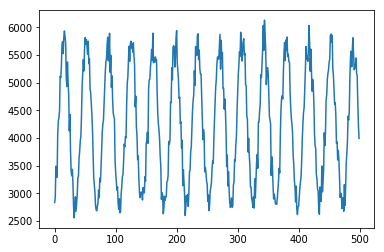

In [250]:
plt.plot(sines[n])
n+=1

In [251]:
np.savetxt("synthetic_sines_low_short.csv" ,sines, delimiter=',')

In [132]:
def generate_boxes(no_boxes=1000,lc_len=500, minimum_period=32.5):
    
    synthetic_boxs=np.zeros((no_boxes, lc_len))
    gamma1=np.random.gamma(4.5, 3, 7000)+minimum_period
    gamma2=np.random.gamma(5, 8.5, 7000)+minimum_period
    gamma=np.concatenate((gamma1,gamma2))
    
    for gen_box in range(generate_boxs):
        gen_y=np.random.normal(np.mean(mean_rates_list), np.std(mean_rates_list))
        gen_interval=np.random.choice(gamma)
        gen_thickness=np.random.normal(np.mean(np.hstack(thickness_list)), np.std(np.hstack(thickness_list)))
        gen_peak=np.random.choice(mean_peak_difference_list)
        revs=int(500//(gen_interval+gen_thickness)+3)
        ys=[]
        for rev in range(revs):
            for i in range(int(gen_interval)):
                ys.append(gen_y)
            for i in range(int(gen_thickness)):
                ys.append(gen_y+gen_peak)
        init_phase=np.random.randint(gen_interval+gen_thickness)
        gen_err=np.power(np.e,np.log(ys)*0.5+1.0397207708265923)
        synthetic_boxs[gen_box,:]=np.array(ys[init_phase:init_phase+500]+np.random.normal(ys, gen_err)[init_phase:init_phase+500])
    return synthetic_boxs

In [133]:
n=0

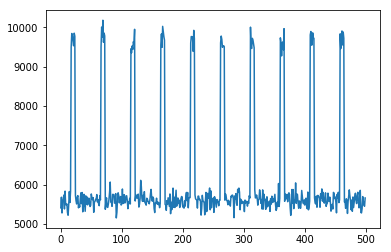

In [149]:
plt.plot(synthetic_boxs[n])
n+=1

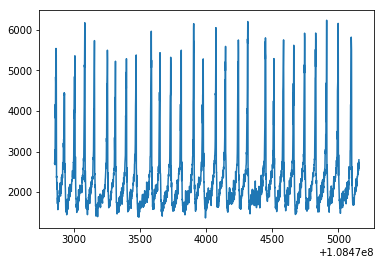

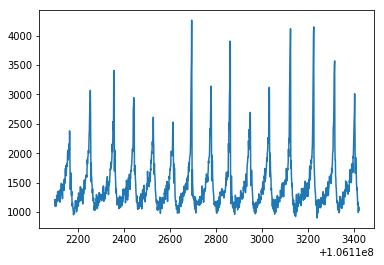

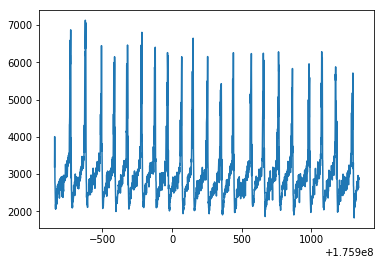

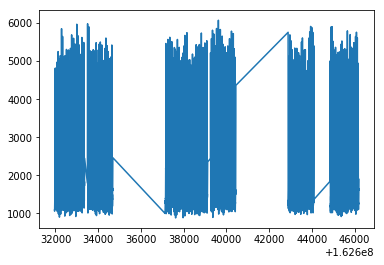

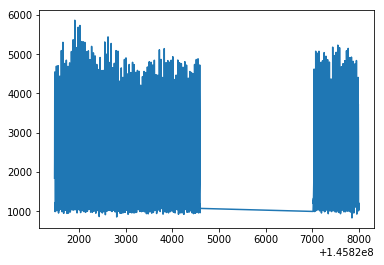

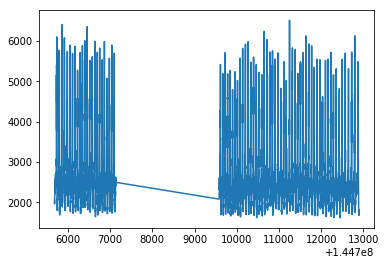

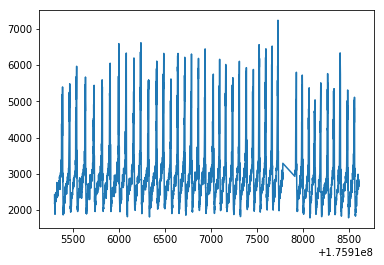

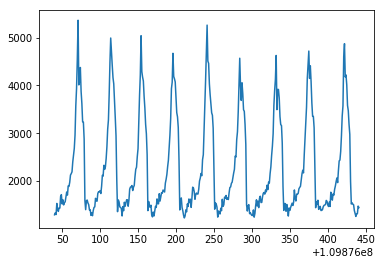

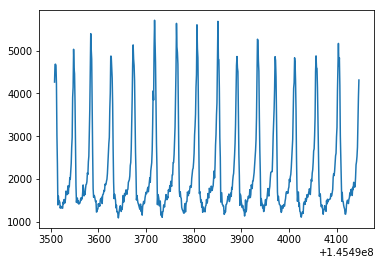

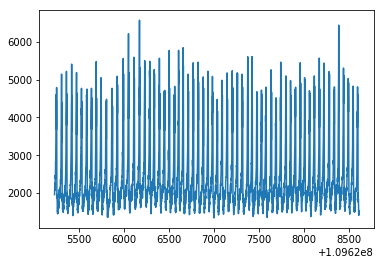

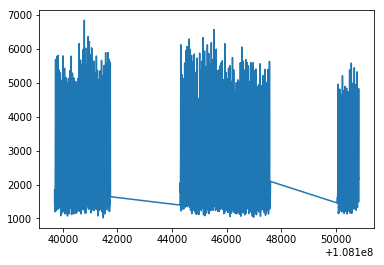

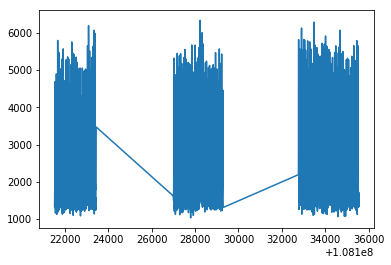

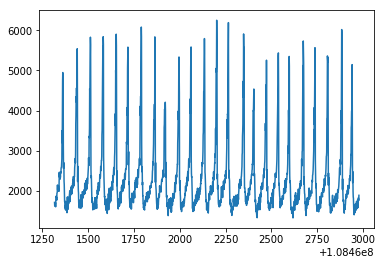

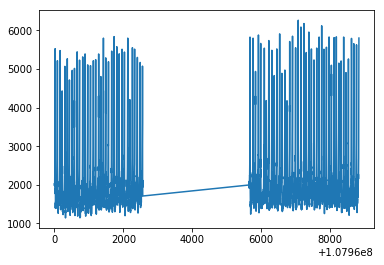

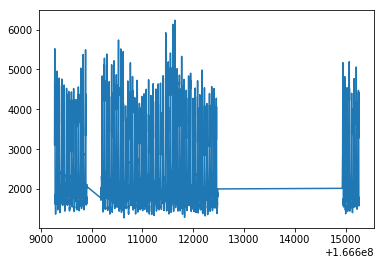

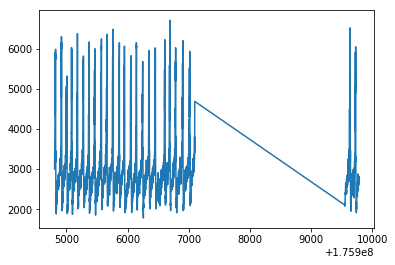

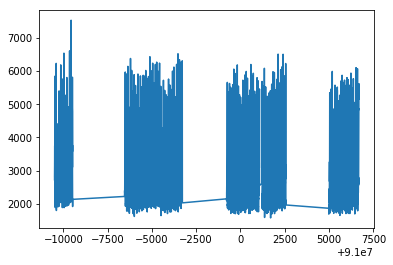

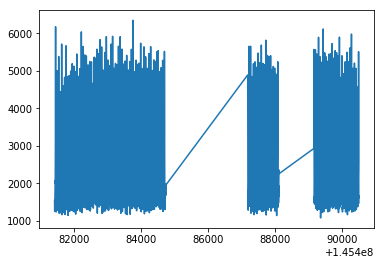

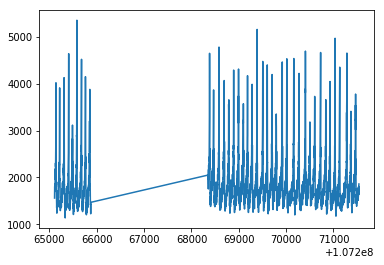

In [267]:
for ob_index, ob_id in enumerate(ids):
    ob_class=ob_state[ob_id]
    if ob_class == "rho":
        xs=lcs[ob_index][0]
        ys=lcs[ob_index][1]
        plt.plot(xs,ys)
        plt.show()